# Гипотеза

Если заменить выбросы в диапазоне $400 > x > 1030$ на значения в предыдущей точке, то качество метрики может улучшиться.  
Лучшее значение метрики f1 binary на текущий момент = 0.8072364316905803 (см. [cardiospike-pipeline](https://github.com/mmezhov/cardiospike/blob/main/pipelines/cardiospike-pipeline.ipynb))

>не подтердилась, f1 = 0.801129234629862

In [69]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score

In [2]:
# Const
RANDOM_STATE = 0

# Полезные методы

In [10]:
def make_XY(df):
    """
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler_hypothesis_3.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler_hypothesis_3.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()

# Подготовка датасета

In [4]:
df = pd.read_csv('../input/cardiospikecompetition/train.csv')
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,5):
        # добавим в признаки 4 следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и 4 предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
    df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
    df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values

In [5]:
print('TEST')
print('- всего ритмограмм в наборе данных', len(df.id.unique()), 'штук\n')
print('- в каждой ритмограмме первые и последние 4 строки \n' \
       'будут с пропусками из-за отсутствия данных о прошлых и будущих точках для \n' \
      'первых и последних 4 точек в радиограмме,\n' \
      'следовательно строк с пропусками должно быть', len(df.id.unique())*8, '\n')
print('- финальный размер датасета должне быть', len(df)-len(df.id.unique())*8, '\n')

print('смотрим, что получается по факту:')
print('df', len(df))
print('df.dropna', len(df.dropna()))
print('разница', len(df) - len(df.dropna()))
if (len(df)-len(df.id.unique())*8 == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому, ' \
          'нужно ещё выбрать контрольный пример для оценки глазами')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
- всего ритмограмм в наборе данных 229 штук

- в каждой ритмограмме первые и последние 4 строки 
будут с пропусками из-за отсутствия данных о прошлых и будущих точках для 
первых и последних 4 точек в радиограмме,
следовательно строк с пропусками должно быть 1832 

- финальный размер датасета должне быть 58655 

смотрим, что получается по факту:
df 60487
df.dropna 58655
разница 1832
Итог: по размеру датасет соответствует ожидаемому, нужно ещё выбрать контрольный пример для оценки глазами
:)


In [6]:
# контрольный пример для оценки глазами
mask = (df.id==3)
display(df[mask].head(10))
display(df[mask].tail(10))

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
2096,3,0,760,0,NaN,28.0,784.0,NaN,772.0,NaN,...,NaN,768.0,NaN,-24.0,-12.0,NaN,0.0,NaN,-8.0,NaN
2097,3,784,784,0,24.0,4.0,772.0,760.0,760.0,NaN,...,NaN,776.0,NaN,12.0,24.0,NaN,16.0,NaN,8.0,NaN
2098,3,1556,772,0,-12.0,16.0,760.0,784.0,768.0,760.0,...,NaN,852.0,NaN,12.0,4.0,12.0,-4.0,NaN,-80.0,NaN
2099,3,2316,760,1,-12.0,28.0,768.0,772.0,776.0,784.0,...,760.0,728.0,NaN,-8.0,-16.0,-24.0,-92.0,0.0,32.0,NaN
2100,3,3084,768,1,8.0,20.0,776.0,760.0,852.0,772.0,...,784.0,800.0,760.0,-8.0,-84.0,-4.0,40.0,-16.0,-32.0,8.0
2101,3,3860,776,1,8.0,12.0,852.0,768.0,728.0,760.0,...,772.0,832.0,784.0,-76.0,48.0,16.0,-24.0,4.0,-56.0,-8.0
2102,3,4712,852,1,76.0,-64.0,728.0,776.0,800.0,768.0,...,760.0,808.0,772.0,124.0,52.0,84.0,20.0,92.0,44.0,80.0
2103,3,5440,728,1,-124.0,60.0,800.0,852.0,832.0,776.0,...,768.0,800.0,760.0,-72.0,-104.0,-48.0,-80.0,-40.0,-72.0,-32.0
2104,3,6240,800,1,72.0,-12.0,832.0,728.0,808.0,852.0,...,776.0,840.0,768.0,-32.0,-8.0,-52.0,0.0,24.0,-40.0,32.0
2105,3,7072,832,1,32.0,-44.0,808.0,800.0,800.0,728.0,...,852.0,808.0,776.0,24.0,32.0,104.0,-8.0,-20.0,24.0,56.0


,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
2191,3,74916,848,1,68.0,-60.0,736.0,780.0,768.0,808.0,...,792.0,780.0,808.0,112.0,80.0,40.0,52.0,56.0,68.0,40.0
2192,3,75652,736,1,-112.0,52.0,768.0,848.0,796.0,780.0,...,808.0,784.0,792.0,-32.0,-60.0,-44.0,-44.0,-72.0,-48.0,-56.0
2193,3,76420,768,1,32.0,20.0,796.0,736.0,780.0,848.0,...,780.0,796.0,808.0,-28.0,-12.0,-80.0,-16.0,-12.0,-28.0,-40.0
2194,3,77216,796,1,28.0,-8.0,780.0,768.0,784.0,736.0,...,848.0,772.0,780.0,16.0,12.0,60.0,0.0,-52.0,24.0,16.0
2195,3,77996,780,1,-16.0,8.0,784.0,796.0,796.0,768.0,...,736.0,804.0,848.0,-4.0,-16.0,12.0,8.0,44.0,-24.0,-68.0
2196,3,78780,784,1,4.0,4.0,796.0,780.0,772.0,796.0,...,768.0,796.0,736.0,-12.0,12.0,-12.0,-20.0,16.0,-12.0,48.0
2197,3,79576,796,0,12.0,-8.0,772.0,784.0,804.0,780.0,...,796.0,NaN,768.0,24.0,-8.0,16.0,0.0,0.0,NaN,28.0
2198,3,80348,772,0,-24.0,16.0,804.0,796.0,796.0,784.0,...,780.0,NaN,796.0,-32.0,-24.0,-12.0,NaN,-8.0,NaN,-24.0
2199,3,81152,804,0,32.0,-16.0,796.0,772.0,NaN,796.0,...,784.0,NaN,780.0,8.0,NaN,8.0,NaN,20.0,NaN,24.0
2200,3,81948,796,0,-8.0,-8.0,NaN,804.0,NaN,772.0,...,796.0,NaN,784.0,NaN,NaN,24.0,NaN,0.0,NaN,12.0


In [7]:
df.dropna(inplace=True)

In [8]:
# проверим сколько точек будет распознано как выбросы и нет ли в них точек с у=1
df[(df.x > 1030)|(df.x < 400)].y.value_counts()

0    10249
Name: y, dtype: int64

In [9]:
# test
if (len(df) - len(df.drop(df[(df.x > 1030)|(df.x < 400)].index))) == 10249:
    print('True')
else:
    print('False')

True


# Замена выбросов

# тестирование алгоритма обработки выбросов

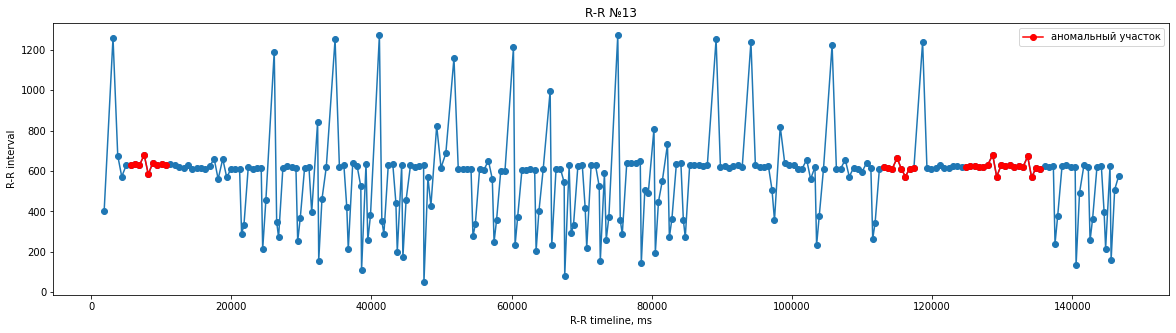

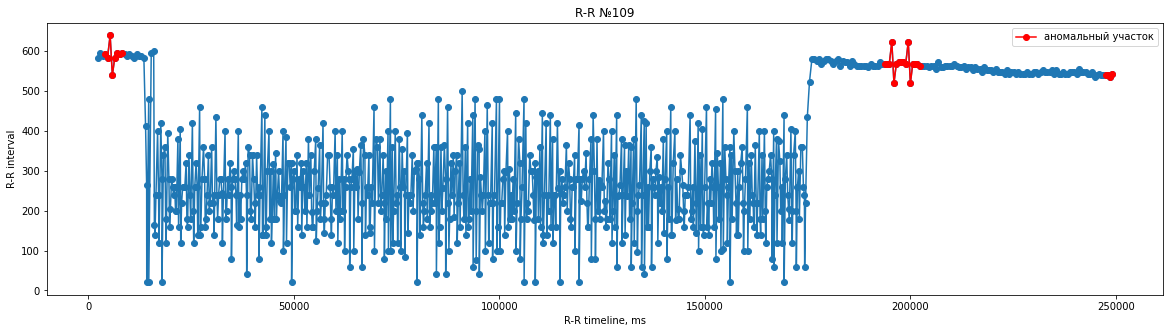

In [13]:
# контрольные примеры: R-R #13, R-R #109
plot_RR([13,109], df)

In [36]:
# test
a = pd.DataFrame({'x': [600, 1031, 700, 200]}, index=[1,2,3,4])
print('1) данные как есть:')
display(a)

print('2) выбросы:')
display(a[a.x > 1030])
display(a[a.x < 400])

a.loc[a.x > 1030, 'x'] = pd.NA
a.loc[a.x < 400, 'x'] = pd.NA

print('3) выбросы заменены на NA')
display(a)

print('4) NA в x заменены значениями из предыдущих точек:')
a.x.ffill(inplace=True)
display(a)

1) данные как есть:


,x
1,600
2,1031
3,700
4,200


2) выбросы:


,x
2,1031


,x
4,200


3) выбросы заменены на NA


,x
1,600
2,<NA>
3,700
4,<NA>


4) NA в x заменены значениями из предыдущих точек:


,x
1,600
2,600
3,700
4,700


Опробуем замену выбросов на данных по двум контрольным ритмограммам:

In [53]:
test_df = df[(df.id == 13)|(df.id == 109)].copy()
test_df

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
3112,13,1868,404,0,-436.0,212.0,1260.0,840.0,676.0,160.0,...,464.0,628.0,632.0,-856.0,-272.0,244.0,-168.0,-60.0,-224.0,-228.0
3113,13,3128,1260,0,856.0,-644.0,676.0,404.0,572.0,840.0,...,160.0,628.0,464.0,584.0,688.0,420.0,632.0,1100.0,632.0,796.0
3114,13,3804,676,0,-584.0,-60.0,572.0,1260.0,628.0,404.0,...,840.0,636.0,160.0,104.0,48.0,272.0,48.0,-164.0,40.0,516.0
3115,13,4376,572,0,-104.0,44.0,628.0,676.0,628.0,1260.0,...,404.0,628.0,840.0,-56.0,-56.0,-688.0,-64.0,168.0,-56.0,-268.0
3116,13,5004,628,0,56.0,-12.0,628.0,572.0,636.0,676.0,...,1260.0,680.0,404.0,0.0,-8.0,-48.0,0.0,-632.0,-52.0,224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20480,109,246936,540,0,0.0,-260.0,540.0,540.0,540.0,544.0,...,540.0,544.0,536.0,0.0,0.0,-4.0,4.0,0.0,-4.0,4.0
20481,109,247476,540,1,0.0,-260.0,540.0,540.0,536.0,540.0,...,544.0,588.0,540.0,0.0,4.0,0.0,-4.0,-4.0,-48.0,0.0
20482,109,248016,540,1,0.0,-260.0,536.0,540.0,544.0,540.0,...,540.0,484.0,544.0,4.0,-4.0,0.0,-48.0,0.0,56.0,-4.0
20483,109,248552,536,1,-4.0,-256.0,544.0,540.0,588.0,540.0,...,540.0,540.0,540.0,-8.0,-52.0,-4.0,52.0,-4.0,-4.0,-4.0


In [55]:
# проверим сколько точек будет распознано как выбросы и нет ли в них точек с у=1
test_df[(test_df.x > 1030)|(test_df.x < 400)].y.value_counts()

0    640
Name: y, dtype: int64

In [58]:
out_cnt = len(test_df[(test_df.x > 1030)|(test_df.x < 400)].y)
out_cnt

640

In [49]:
print('количество выбрасов выше 1030 =', len(test_df[test_df.x > 1030]))
print('количество выбрасов ниже 400 =', len(test_df[test_df.x < 400]))

количество выбрасов выше 1030 = 11
количество выбрасов ниже 400 = 629


In [61]:
test_df.loc[test_df.x > 1030, 'x'] = pd.NA
test_df.loc[test_df.x < 400, 'x'] = pd.NA

print('количество NA после мьютирования =', len(test_df[test_df.x.isna()]))
if len(test_df[test_df.x.isna()]) == out_cnt:
    print('выбросы замьютированы корректно')
else:
    print('мьютирование выбросов прошло некорректно...')

количество NA после мьютирования = 640
выбросы замьютированы корректно


In [63]:
# сохраним индексы для дальнейшей провреки, где данные замьютированы
out_ind = test_df[test_df.x.isna()].index

In [64]:
test_df.x.ffill(inplace=True)

In [109]:
# проверка на корректность мьютирования
ind = np.random.randint(len(out_ind))
test_df.loc[[out_ind[ind]-1, out_ind[ind]], 'x']

20005    460
20006    460
Name: x, dtype: int64

на нескольких итерация показало, что всё в порядке

было


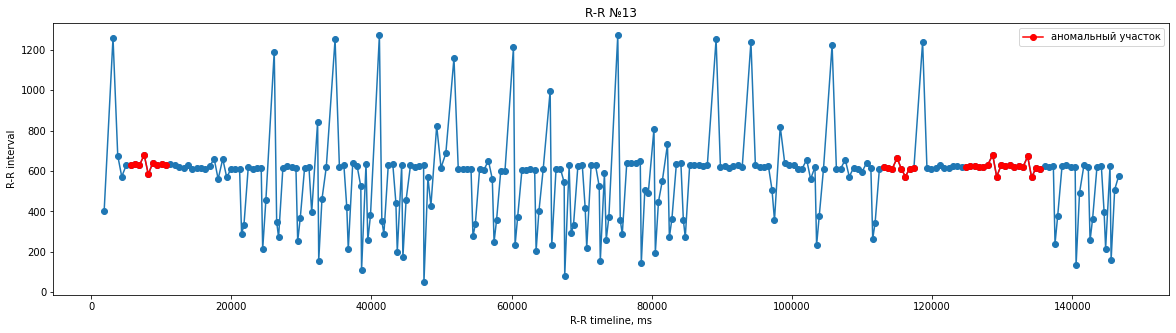

стало


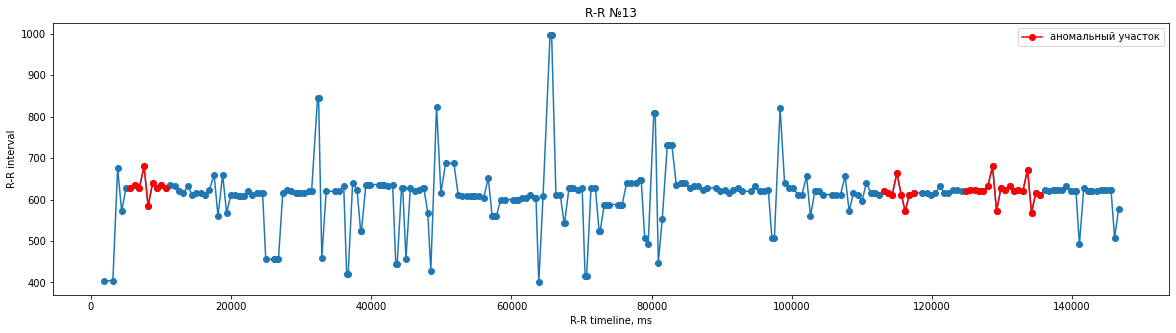

было


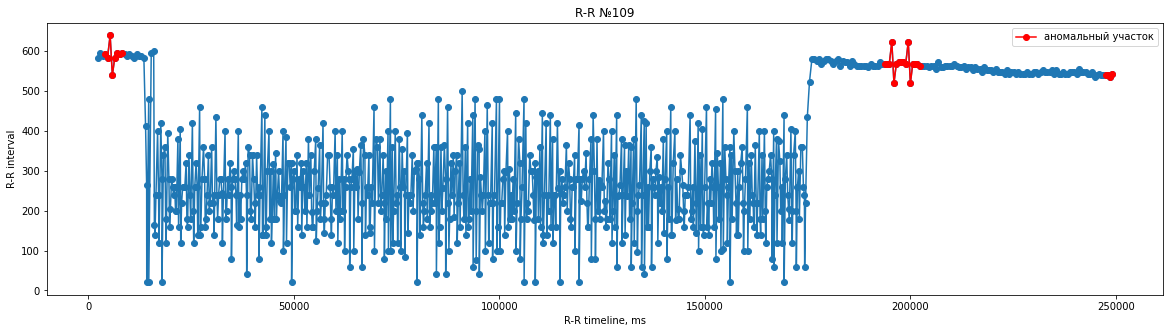

стало


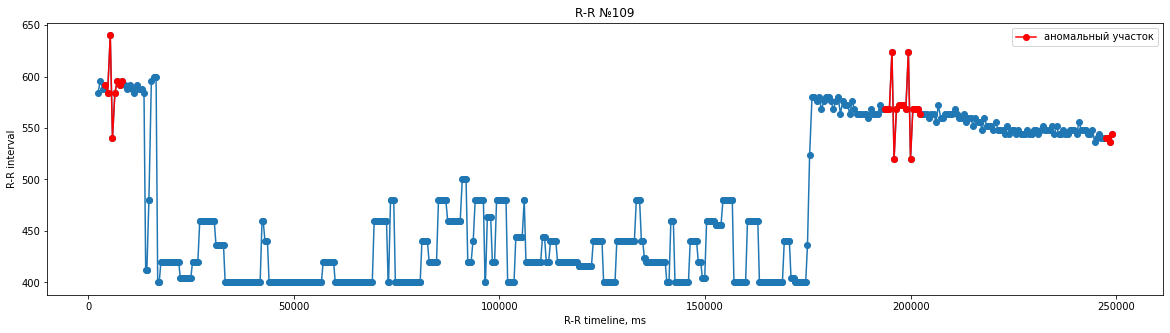

In [113]:
# посмотрим как изменились графики после очистки от выбросов
print('было')
plot_RR([13], df)
print('стало')
plot_RR([13], test_df)
print('было')
plot_RR([109], df)
print('стало')
plot_RR([109], test_df)

Попробуем таким образом очистить весть датафрейм и посчитать метрику

## Очистка основного датасета

In [114]:
# проверим сколько точек будет распознано как выбросы и нет ли в них точек с у=1
df[(df.x > 1030)|(df.x < 400)].y.value_counts()

0    10249
Name: y, dtype: int64

In [115]:
print('количество выбрасов выше 1030 =', len(df[df.x > 1030]))
print('количество выбрасов ниже 400 =', len(df[df.x < 400]))

количество выбрасов выше 1030 = 1188
количество выбрасов ниже 400 = 9061


In [116]:
out_cnt = len(df[(df.x > 1030)|(df.x < 400)].y)
df.loc[df.x > 1030, 'x'] = pd.NA
df.loc[df.x < 400, 'x'] = pd.NA

print('количество NA после мьютирования =', len(df[df.x.isna()]))
if len(df[df.x.isna()]) == out_cnt:
    print('выбросы замьютированы корректно')
else:
    print('мьютирование выбросов прошло некорректно...')

количество NA после мьютирования = 10249
выбросы замьютированы корректно


In [117]:
out_ind = df[df.x.isna()].index
df.x.ffill(inplace=True)
# проверка на корректность мьютирования
ind = np.random.randint(len(out_ind))
df.loc[[out_ind[ind]-1, out_ind[ind]], 'x']

18133    400
18134    400
Name: x, dtype: int64

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58655 entries, 4 to 60482
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  58655 non-null  int64  
 1   time                58655 non-null  int64  
 2   x                   58655 non-null  int64  
 3   y                   58655 non-null  int64  
 4   x_diff              58655 non-null  float64
 5   x_deviation_median  58655 non-null  float64
 6   x+1                 58655 non-null  float64
 7   x-1                 58655 non-null  float64
 8   x+2                 58655 non-null  float64
 9   x-2                 58655 non-null  float64
 10  x+3                 58655 non-null  float64
 11  x-3                 58655 non-null  float64
 12  x+4                 58655 non-null  float64
 13  x-4                 58655 non-null  float64
 14  x-(x+1)             58655 non-null  float64
 15  x-(x+2)             58655 non-null  float64
 16  x-(x

In [119]:
# сохраним датасет в с текущими признаками, предварительно удалив строки с пропусками
with open('dataset_hypothesis_3.pkl', 'wb') as f:
    pickle.dump(df, f)
    
df.to_csv('dataset_hypothesis_3.csv')

# X, y

In [132]:
# make X and y
X,y = make_XY(df)

scaler_hypothesis_3.pkl was saved in output directory


# Cross validation

In [133]:
# LGBMClassifier with default params
baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(baseline, X, y, cv=StratifiedKFold(), scoring='f1')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.79236884 0.68269762 0.56191203 0.75039645 0.75734626]
mean test_score = 0.708944239080732


In [123]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(model, X, y, cv=StratifiedKFold(), scoring='f1')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.80351538 0.69484808 0.56544503 0.75235701 0.76007109]
mean test_score = 0.715247317745437


>Лучшее значение метрики f1 binary на текущий момент = 0.8072364316905803 (см. [cardiospike-pipeline](https://github.com/mmezhov/cardiospike/blob/main/pipelines/cardiospike-pipeline.ipynb))  
>Воспроизведём кросс-валидацию на данных без очистки:

In [135]:
with open('../pipelines/dataset.pkl', 'rb') as f:
    test_df = pickle.load(f)
X,y = make_XY(test_df)

scaler_hypothesis_3.pkl was saved in output directory


In [137]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(model, X, y, cv=StratifiedKFold(), scoring='f1')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.80723643 0.69782095 0.55931778 0.75157233 0.76404494]
mean test_score = 0.7159984871459176


>действительно среднее значение метрики выше, чем при использовании очистки, предложенной в данной гипотезе

Посмотрим как на очищенных данных обучается модель

In [138]:
# make X and y
X,y = make_XY(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler_hypothesis_3.pkl was saved in output directory
train (46924, 18) (46924,)
test (11731, 18) (11731,)


previous best score = 0.8072364316905803
model score = 0.7967479674796748


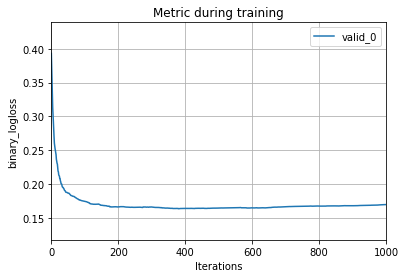

In [140]:
model = lgb.LGBMClassifier(n_estimators=1000, random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model);

y_pred = model.predict(X_test)
print('previous best score =', 0.8072364316905803)
print('model score =', f1_score(y_test, y_pred))

previous best score = 0.8072364316905803
model score = 0.801129234629862
best_iteration_ 4136


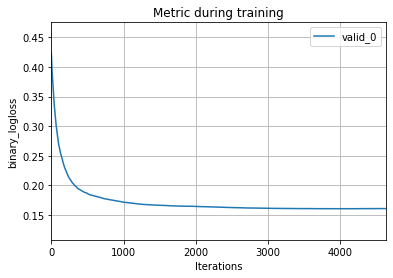

In [143]:
model = lgb.LGBMClassifier(n_estimators=6000, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, early_stopping_rounds=500)
lgb.plot_metric(model);

y_pred = model.predict(X_test)
print('previous best score =', 0.8072364316905803)
print('model score =', f1_score(y_test, y_pred))
print('best_iteration_', model.best_iteration_)